# Modeling - Stroke Prediction
**Anh Kieu - Rafe Batchelor**


In this notebook, we will present and test different models that we pick for this dataset, train and evaluate using cross-validation (k-fold). Before we get into modeling, we will handle the imbalance dataset with different synthesis sampling method. We wish that we would be able to produce models with reasonable recall.

## Preprocessing I - Basic data preprocessing

In [6]:
# import libaries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [56]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV

In [19]:
# import data
df = pd.read_csv("./data/healthcare-dataset-stroke-data.csv")

In [20]:
# drop id as it is unique value, which we can use index for.
df.drop(columns = ['id'], inplace = True)

In [21]:
df = df.rename(columns = {'Residence_type' : 'residence_type'}) # change variable name for convenience.

In [22]:
cat_vars = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status", "stroke"] # categorize
for col in cat_vars:
    df[col] = pd.Categorical(df[col], ordered = False)

In [23]:
# downcast:
for column in df.columns[1:]:
    if column == 'age':
        df[column] = pd.to_numeric(df[column], downcast = 'unsigned')
    elif column == 'avg_glucose_level' or column == 'bmi':
        df[column] = pd.to_numeric(df[column], downcast = 'float')

In [24]:
df = df.loc[df['gender'] != "Other"] # change gender

In [25]:
df['gender'] = pd.Categorical(df['gender'], categories = ["Female", "Male"], ordered = False)

## Preprocessing II - Data processing for modeling
- Normalize, binary encode, N/A value with impute
- Dropping unrelated attribute
- Resampling

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
# normalize
scaler = MinMaxScaler()
df.loc[:, ['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(df.loc[:, ['age','avg_glucose_level', 'bmi']])

In [28]:
from sklearn.impute import KNNImputer

In [29]:
# impute
imputer = KNNImputer(n_neighbors = 2)
df.loc[:,['age','avg_glucose_level', 'bmi']] = imputer.fit_transform(df.loc[:,['age','avg_glucose_level', 'bmi']])

In [34]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,0.816895,0,1,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1
1,Female,0.743652,0,0,Yes,Self-employed,Rural,0.679023,0.276632,never smoked,1
2,Male,0.975586,0,1,Yes,Private,Rural,0.234512,0.254296,never smoked,1
3,Female,0.597168,0,0,Yes,Private,Urban,0.536008,0.276060,smokes,1
4,Female,0.963379,1,0,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,1


In [37]:
# cat_vars = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status", "stroke"]
df_stroke = pd.get_dummies(df, columns = cat_vars[:-1])

In [38]:
df_stroke.head()

,age,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0.801265,0.301260,1,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
1,0.743652,0.679023,0.276632,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
2,0.975586,0.234512,0.254296,1,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
3,0.597168,0.536008,0.276060,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0.963379,0.549349,0.156930,1,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0


__________________________

Splitting dataset to train and test

In [138]:
X, y = df_stroke.iloc[:, df_stroke.columns != 'stroke'], df_stroke['stroke']

In [139]:
X, y = shuffle(X, y, random_state = 0)

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 0)

In [141]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3576, 22)
X_test: (1533, 22)
y_train: (3576,)
y_test: (1533,)


As mentioned, our dataset is imbalance, unfortunately (for the purpose of data analysis and stroke prediction), with a lot more no-stroke observations than stroke observations. Thus, we will have to resample the training data to make it balance. 

**SMOTE** - Synthetic Minority Oversampling Technique (why not SMOT??) \
SMOTE is a technique that generates synthetic sample of the minority class. This helps with overfitting problem posed by random oversampling. It uses interpolation based on the datapoints of the minority class to generate in-between point. \
Some potential drawbacks: 
- The synthetic instances are in the same trend as the original sample, thus, could create bias
- Tends to create a large number of noisy data points in feature space
More on SMOTE: https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/, https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [142]:
from imblearn.over_sampling import SMOTE

In [143]:
from collections import Counter
counter = Counter(y_train)
print('Before', counter)

Before Counter({0: 3393, 1: 183})


In [144]:
smt = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
counter = Counter(y_train_sm)
print('After', counter)

After Counter({0: 3393, 1: 3393})


As we see over with the counter value, we will obtain a balance dataset to train on.

## Modeling and Evaluation
We will be performing gridsearch with smote on different models. More on example of doing gridsearch and smote: https://medium.com/swlh/detecting-credit-card-fraud-with-smote-and-gridsearch-pipeline-d11f63f2fef2

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [75]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [129]:
from imblearn.pipeline import Pipeline, make_pipeline

In [228]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [73]:
def Model(model, oversam_mode = 'normal'):
    ## using all default models
    if oversam_mode == 'normal':
        model.fit(X_train, y_train)
    elif oversam_mode == 'smote':
        model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap="Blues", annot = True, fmt = 'd')
    
    print(classification_report(y_test, y_pred))

In [265]:
# ref for params: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
lrc_param = {
     'model__penalty' : ['l1', 'l2'],
    'model__C' : [0.25, 0.5, 0.75, 1],
    'model__random_state' : [42]
}

dtc_param = {
    'model__criterion' : ['gini','entropy'],
    'model__max_depth' : [4,5,6,7,8],
    'model__min_samples_split' : [2,3,4,5],
    'model__min_samples_leaf': [1,2,3,4,5], 
    'model__random_state' : [42]
}

rfc_param = {
    'model__n_estimators' :[100,200],
    'model__max_depth' : [4,5,6],
    'model__min_samples_split' : [3,4,5],
    'model__min_samples_leaf': [2,3,4],
    'model__random_state' : [42]
}

In [236]:
def plot_pr(model, name):
    # ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
    # predict probabilities
    yhat = model.predict_proba(X_test)
    # retrieve just the probabilities for the positive class
    pos_probs = yhat[:, 1]
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, pos_probs)
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label= name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.title(f'Precision - Recall For {name} Classifier')
    plt.show()

### Decision Tree

In [156]:
pipeline = Pipeline([('smt', smt), ('model', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smt', SMOTE()), ('model', DecisionTreeClassifier())])

In [177]:
grid = GridSearchCV(pipeline, param_grid = dtc_param, cv = 5, scoring = ['recall', 'f1_macro'], refit = "f1_macro",
                   return_train_score = True, n_jobs = 2)
grid = grid.fit(X_train, y_train)

In [178]:
grid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 5,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 4}

Decision Tree Classifier performance:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1467
           1       0.12      0.74      0.21        66

    accuracy                           0.76      1533
   macro avg       0.55      0.75      0.54      1533
weighted avg       0.95      0.76      0.83      1533



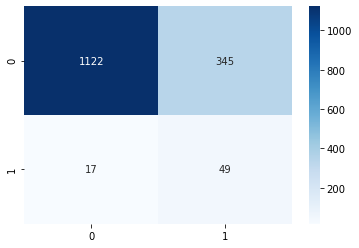

In [213]:
print('Decision Tree Classifier performance:')
clf_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 2, min_samples_split = 4)
Model(clf_dt, 'smote')

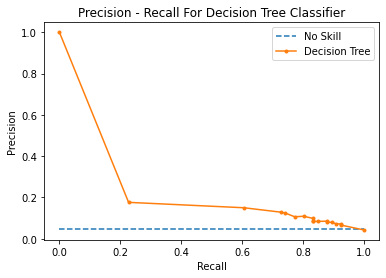

In [237]:
plot_pr(clf_dt, 'Decision Tree')

Our model of Decision Tree Classifier only reaches high recall at quite low precision.

### Random Forest

In [209]:
pipeline_rf = Pipeline([('smt', smt), ('model', RandomForestClassifier())])
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('smt', SMOTE()), ('model', RandomForestClassifier())])

In [210]:
grid_rf = GridSearchCV(pipeline_rf, param_grid = rfc_param, cv = 5, scoring = ['recall', 'f1_macro'], refit = "f1_macro",
                   return_train_score = True, n_jobs = 2)
grid_rf = grid_rf.fit(X_train, y_train)

In [211]:
grid_rf.best_params_

{'model__max_depth': 6,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

Random Forest Classifier Performance
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1467
           1       0.12      0.79      0.21        66

    accuracy                           0.75      1533
   macro avg       0.56      0.77      0.53      1533
weighted avg       0.95      0.75      0.82      1533



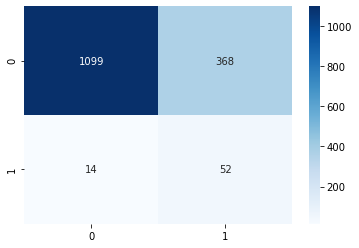

In [220]:
print('Random Forest Classifier Performance')
clf_rf = RandomForestClassifier(n_estimators = 100, max_depth = 6, min_samples_leaf = 4, min_samples_split = 4)
Model(clf_rf, 'smote')

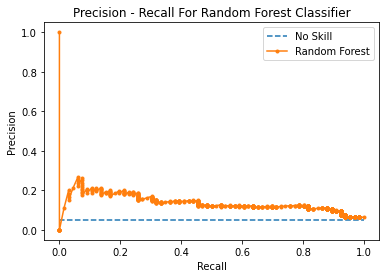

In [239]:
plot_pr(clf_rf, 'Random Forest')

Same with Decision Tree, we are able to acquire a high recall, but with a loss for precision. The recall is slightly better with Random Forest though

### Logistic Regression

In [243]:
pipeline_lr = Pipeline([('smt', smt), ('model', LogisticRegression())])
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('smt', SMOTE()), ('model', LogisticRegression())])

In [274]:
import warnings
warnings.filterwarnings('ignore')
grid_lr = GridSearchCV(pipeline_lr, param_grid = lrc_param, cv = 5, scoring = ['recall', 'f1_macro'], refit = "f1_macro",
                   return_train_score = True, n_jobs = 2)
grid_lr = grid_lr.fit(X_train, y_train)

In [275]:
grid_lr.best_params_

{'model__C': 0.25, 'model__penalty': 'l2', 'model__random_state': 42}

Random Forest Classifier Performance
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      1467
           1       0.15      0.48      0.23        66

    accuracy                           0.86      1533
   macro avg       0.56      0.68      0.58      1533
weighted avg       0.94      0.86      0.90      1533



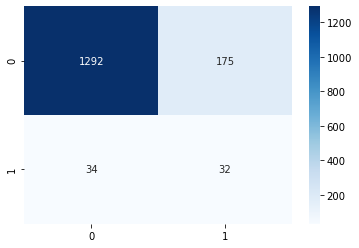

In [276]:
print('Random Forest Classifier Performance')
clf_lr = LogisticRegression(C = 0.25, penalty = 'l2', random_state = 42)
Model(clf_lr, 'smote')

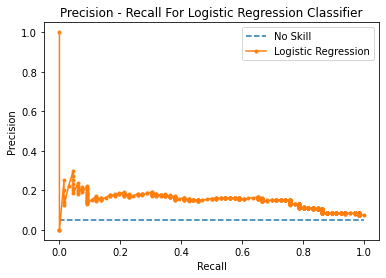

In [273]:
plot_pr(clf_lr, 'Logistic Regression')

Logistic Regression obtains a slightly higher precision for class 1, but the recall rate is not really as good as the other 2 models. 